<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Logistic Regression

_Authors: Kiefer Katovich, Matt Brems, Noelle Brown_

---

### Learning Objectives
- Distinguish between regression and classification problems.
- Understand how logistic regression is similar to and different from linear regression.
- Fit, generate predictions from, and evaluate a logistic regression model in `sklearn`.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.

<a id='introduction'></a>

## Introduction

---

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - Example: What is the probability that someone shows up to vote?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - Example: Based on the predicted probability, do we predict that someone votes?

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to predicting outcomes with 3 or more classes.

**Some examples of when logistic regression could be used:**
- Will a user will purchase a product, given characteristics like income, age, and number of family members?
- Does this patient have a specific disease based on their symptoms?
- Will a person default on their loan?
- Is the iris flower in front of me an "_Iris versicolor_?"
- Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?

And many more.

In [23]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# stylistic choice
plt.style.use('fivethirtyeight')

# Import train_test_split.
from sklearn.model_selection import train_test_split

# Import logistic & linear regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

## Graduate School Admissions

---

Today, we'll be applying logistic regression to solve the following problem: "Given one's GPA, will a student be admitted to a specific graduate program?"

In [2]:
# Read in the data.
df = pd.read_csv('admissions.csv')

In [3]:
# Check first five rows.
df.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   admit     400 non-null    int64  
 1   gre       398 non-null    float64
 2   gpa       398 non-null    float64
 3   prestige  399 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


In [5]:
df.describe()

,admit,gre,gpa,prestige
count,400.000000,398.000000,398.00000,399.000000
mean,0.317500,588.040201,3.39093,2.486216
std,0.466087,115.628513,0.38063,0.945333
min,0.000000,220.000000,2.26000,1.000000
25%,0.000000,520.000000,3.13000,2.000000
50%,0.000000,580.000000,3.39500,2.000000
75%,1.000000,660.000000,3.67000,3.000000
max,1.000000,800.000000,4.00000,4.000000


In [6]:
df.groupby('admit').describe()

gre                                                             \
       count        mean         std    min    25%    50%    75%    max   
admit                                                                     
0      271.0  573.579336  116.052798  220.0  500.0  580.0  660.0  800.0   
1      127.0  618.897638  108.884884  300.0  540.0  620.0  680.0  800.0   

         gpa            ...              prestige                           \
       count      mean  ...     75%  max    count      mean       std  min   
admit                   ...                                                  
0      272.0  3.345404  ...  3.6100  4.0    273.0  2.641026  0.917198  1.0   
1      126.0  3.489206  ...  3.7575  4.0    126.0  2.150794  0.921455  1.0   

                           
       25%  50%  75%  max  
admit                      
0      2.0  3.0  3.0  4.0  
1      1.0  2.0  3.0  4.0  

[2 rows x 24 columns]

The four columns are:
- `admit`: A binary 0/1 variable indicating whether or not a student was admitted, where 1 means admitted and 0 means not admitted.
- `gre`: The student's [GRE (Graduate Record Exam)](https://en.wikipedia.org/wiki/Graduate_Record_Examinations) score.
- `gpa`: The student's GPA.
- `prestige`: A 1-4 rating for the college's "prestige."

In [7]:
df.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [8]:
# How many missing values do we have in each column?
df[df['prestige'].isnull() | df['gre'].isnull() | df['gpa'].isnull()]

,admit,gre,gpa,prestige
187,0,NaN,NaN,2.0
212,0,NaN,2.87,2.0
236,1,660.0,NaN,NaN


In [9]:
# Drop every row that has an NA.
df.dropna(subset=['gre','gpa','prestige'], inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   admit     397 non-null    int64  
 1   gre       397 non-null    float64
 2   gpa       397 non-null    float64
 3   prestige  397 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 15.5 KB


In [13]:
df

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0
...,...,...,...,...
395,0,620.0,4.00,2.0
396,0,560.0,3.04,3.0
397,0,460.0,2.63,2.0
398,0,700.0,3.65,2.0


In [14]:
df = df.reset_index()

In [15]:
df

,index,admit,gre,gpa,prestige
0,0,0,380.0,3.61,3.0
1,1,1,660.0,3.67,3.0
2,2,1,800.0,4.00,1.0
3,3,1,640.0,3.19,4.0
4,4,0,520.0,2.93,4.0
...,...,...,...,...,...
392,395,0,620.0,4.00,2.0
393,396,0,560.0,3.04,3.0
394,397,0,460.0,2.63,2.0
395,398,0,700.0,3.65,2.0


<details><summary>What assumption are we making when we drop rows that have at least one NA in it?</summary>
    
- We assume that what we drop looks like what we have observed. That is, there's nothing special about the rows we happened to drop.
- We might say that what we dropped is a random sample of our whole data.
- It's not important to know this now, but the formal term is that our data is missing completely at random.
</details>

<details><summary>Suppose I want to check if a value of 1 for prestige means "most prestigious" or "least prestigious." How might I find this out?</summary>
    
- Check a data dictionary to see if the answer exists.
- If a data dictionary doesn't exist, compare prestige to admit. You could use [groupby](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.groupby.html) to make a table or you could use a plot.
</details>

In [19]:
df.groupby('admit')['prestige'].mean()

admit
0    2.645756
1    2.150794
Name: prestige, dtype: float64

From the code above, we can see that the lower the prestige number, the more prestigious the university may be

In [25]:
#checking for class imbalances
df['admit'].value_counts()

0    271
1    126
Name: admit, dtype: int64

In [26]:
271/len(df)

0.6826196473551638

## A Very Naive Model => Base model

In [21]:
# Model that says no one is admitted to the university
df['naive_pred'] = 0

In [22]:
df

,index,admit,gre,gpa,prestige,naive_pred
0,0,0,380.0,3.61,3.0,0
1,1,1,660.0,3.67,3.0,0
2,2,1,800.0,4.00,1.0,0
3,3,1,640.0,3.19,4.0,0
4,4,0,520.0,2.93,4.0,0
...,...,...,...,...,...,...
392,395,0,620.0,4.00,2.0,0
393,396,0,560.0,3.04,3.0,0
394,397,0,460.0,2.63,2.0,0
395,398,0,700.0,3.65,2.0,0


In [24]:
# accuracy of the model => how many correctly predicted vs actual data=> y_pred vs y_true
accuracy_score(df['admit'], df['naive_pred'])

0.6826196473551638

### Artificially increase the signal in the data.

The signal for detecting admission in the college data is fairly weak — too weak for the purposes of our demonstration. (There are lots of factors associated with getting admitted to grad school other than GPA, test score, and prestige.)

**Obviously you would never do this to your real data**... but in order to make the relationship between our predictors and whether or not someone is admitted a lot clearer, we are making 10 copies of the data set and adding an artificial signal for detecting `admit` to the `gpa` column.

In [28]:
admit = df[df['prestige'] == 1]
admit

,index,admit,gre,gpa,prestige,naive_pred
2,2,1,800.0,4.00,1.0,0
6,6,1,560.0,2.98,1.0,0
11,11,0,440.0,3.22,1.0,0
12,12,1,760.0,4.00,1.0,0
14,14,1,700.0,4.00,1.0,0
...,...,...,...,...,...,...
365,368,0,580.0,4.00,1.0,0
369,372,1,680.0,2.42,1.0,0
370,373,1,620.0,3.37,1.0,0
380,383,0,660.0,4.00,1.0,0


In [29]:
admit['admit'].value_counts()

1    33
0    28
Name: admit, dtype: int64

In [30]:
# Grab all rows where prestige = 1.

# Concatenate ten copies of admit.
admit = pd.concat([admit] * 10, axis=0)

# Set a random seed.
np.random.seed(42)

# Add random noise to inflate GPA for people who were admitted.
# Subtract random noise to deflate GPA for people who were not admitted.
# Again: DO NOT DO THIS IN GENERAL.
admit.loc[admit['admit'] == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit['admit'] == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

In [39]:
admit['admit'].value_counts()

1    330
0    280
Name: admit, dtype: int64

In [40]:
admit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 2 to 382
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       610 non-null    int64  
 1   admit       610 non-null    int64  
 2   gre         610 non-null    float64
 3   gpa         610 non-null    float64
 4   prestige    610 non-null    float64
 5   naive_pred  610 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 33.4 KB


## Linear Regression Notation

**linear** regression:

### $$
\begin{eqnarray*}
\hat{Y} &=& \hat{\beta}_0 + \hat{\beta}_1X_1 + \hat{\beta}_2X_2 + \cdots + \hat{\beta}_pX_p \\
&=& \hat{\beta}_0 + \sum_{j=1}^p\hat{\beta}_jX_j
\end{eqnarray*}
$$

Where:
- $\hat{Y}$ is the predicted value of $Y$ based on all of the inputs $X_j$.
- $X_1$, $X_2$, $\ldots$, $X_p$ are the predictors.
- $\hat{\beta}_0$ is the estimated intercept.
- $\hat{\beta}_j$ is the estimated coefficient for the predictor $X_j$, the $j$th column in variable matrix $\mathbf{X}$.


<a id='pred-admit'></a>

## What If We Predicted `admit` With `gpa` Using Linear Regression?

Let's try predicting the `admit` binary indicator using just `gpa` with a linear regression to see what goes wrong.

In [53]:
# Define y and X.
y = admit['admit']
X = admit[['gpa']] # Because X is a matrix, we'll get a 
                   # reshape request if we don't use double brackets.

# Create training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

# Instantiate a linear regression model.
lr = LinearRegression() #leaving to default params

# Fit our linear regression model to the training data. ALWAYS FIT ON TRAINING SET
lr.fit(X_train, y_train)

# Print out intercept and coefficients.
print(f'Intercept: {lr.intercept_}')
print(f'Coefficient: {lr.coef_}')

Intercept: -1.2044437102734054
Coefficient: [0.5020687]


In [55]:
X_train.shape

(488, 1)

In [56]:
lr.predict(X_train)

array([ 3.63185019e-01,  8.28408819e-01,  1.68252175e-02,  7.36802786e-01,
        2.21930888e-02,  2.97086295e-01,  7.52590764e-01,  7.44954902e-01,
        8.87956439e-01,  1.21324873e+00,  2.64902909e-01,  3.64825478e-01,
        8.15356804e-01,  1.21056365e+00, -1.71800131e-01,  7.09089443e-01,
        1.27723652e+00,  4.13076572e-01,  9.63775450e-01,  3.96549887e-01,
        9.10974424e-01,  1.75038198e-02,  7.47764892e-01,  2.38985414e-02,
        1.68160576e-01,  1.00723559e+00,  5.32859466e-01,  8.29011075e-01,
        1.23871101e+00,  6.05690040e-01,  6.46400932e-01,  7.69006940e-01,
        5.82902742e-01,  3.63279847e-01,  4.39470030e-01,  3.28868891e-01,
        7.69303382e-01,  9.91875947e-01,  8.26099859e-01,  1.17430602e+00,
        1.10869510e+00,  6.43161085e-01,  9.68906557e-01,  4.79364370e-01,
        1.01090562e+00,  8.07940082e-01,  6.61621790e-01,  8.96640713e-01,
        7.45138105e-01,  3.13956582e-01,  9.38421928e-01,  1.15210211e+00,
        7.26879003e-01,  

In [35]:
X_test

,gpa
118,4.609320
220,3.559342
361,3.967545
332,3.989934
118,4.197249
...,...
354,2.817884
206,4.005583
274,4.122645
369,2.700935


In [37]:
lr.predict([[4.609320]])

/Users/premchandran/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([1.10975158])

In [43]:
# make my own linear regression equation => y = wX + c
y_hat = lr.coef_ * 4.609320 + lr.intercept_
y_hat

array([1.10975158])

In [44]:
y_preds_lr = lr.predict(X_test)
y_preds_lr

array([ 1.10975178,  0.58259061,  0.78753636,  0.7987772 ,  0.90286338,
        0.78635071,  0.97958216, -0.04431485,  0.96749252,  0.46073301,
        0.73893734,  0.98609153,  0.27084547,  1.16139397,  0.06777584,
        1.06093697,  0.87411746,  0.58590428,  0.36900312,  0.23349476,
        0.22484005,  0.33132284,  0.20394961,  0.79569535, -0.00480817,
        0.67403203,  0.14699696,  0.47226202,  0.80058255,  0.05216048,
       -0.34835398,  0.52792983, -0.04024208,  0.29697886,  0.30670996,
        0.88657767,  0.76825016,  0.71835461,  0.62642399,  0.48592024,
        0.37264084,  0.77880732,  0.28036575,  0.30772637,  0.63739154,
        0.22123059,  0.27044608,  0.86401173,  0.17716403,  0.61706894,
        1.04143035,  0.77420015,  0.9059007 ,  0.70280481,  0.88892728,
        0.24514761,  0.62094258,  0.24441509,  1.0120673 ,  1.2506749 ,
        1.24136416,  0.21057873, -0.08485542,  0.09045435,  0.12263009,
        0.94893253,  1.07407753,  0.30750062,  0.10282156,  0.77

In [46]:
print(f'Prediction of first GPA is {y_preds_lr[0]}')
print(f'Prediction of second GPA is {y_preds_lr[1]}')
print(f'Prediction of third GPA is {y_preds_lr[2]}')
y_preds_lr[:3]

Prediction of first GPA is 1.1097517780860064
Prediction of second GPA is 0.5825906113271104
Prediction of third GPA is 0.7875363638375259


array([1.10975178, 0.58259061, 0.78753636])

In [47]:
y_hat_1 = lr.coef_ * 4.609320 + lr.intercept_
y_hat_2 = lr.coef_ * 3.559342 + lr.intercept_
y_hat_3 = lr.coef_ * 3.967545 + lr.intercept_

In [48]:
print(y_hat_1,y_hat_2,y_hat_3)

[1.10975158] [0.58259049] [0.78753644]


<a id='plot-reg'></a>
### What do those coefficients mean?  Plot `admit` (our $Y$) against `gpa` (our $X$).

Looking at the plot below, what are problems with using a regression?

/Users/premchandran/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


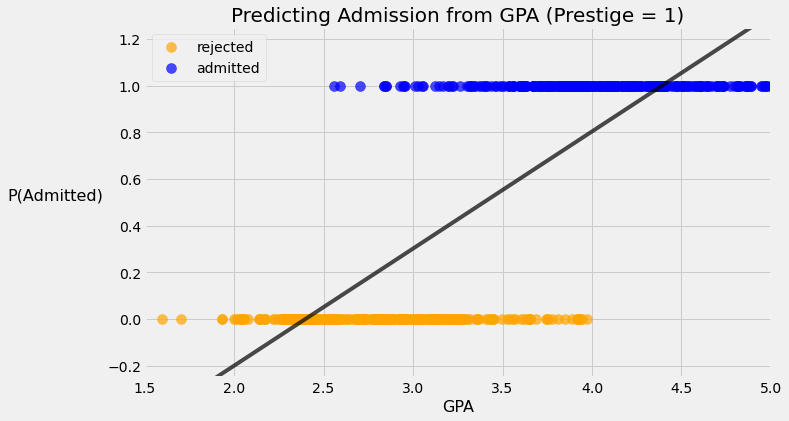

In [42]:
# Create figure.
plt.figure(figsize=(10,6))

# Plot the regression line where gpa predicts admit.
x_vals = np.linspace(1, 5, 300)

# Plot line of best fit
plt.plot(x_vals,
         lr.predict(x_vals.reshape(-1,1)),
         color='black', alpha=0.7, lw=4)

# Create scatterplot with orange dots for those rejected.
plt.scatter(admit['gpa'][admit['admit'] == 0],
            admit['admit'][admit['admit'] == 0],
            c='orange',
            s=100,
            alpha=0.7,
            label='rejected')

# Create scatterplot with blue dots for those admitted.
plt.scatter(admit['gpa'][admit['admit'] == 1],
            admit['admit'][admit['admit'] == 1],
            c='blue',
            s=100,
            alpha=0.7,
            label='admitted')

# Set labels of axes and title.
plt.ylabel('P(Admitted)', fontsize=16, rotation = 'horizontal', ha = 'right')
plt.yticks(fontsize = 14)
plt.xlabel('GPA', fontsize=16)
plt.xticks(fontsize = 14)
plt.title('Predicting Admission from GPA (Prestige = 1)', fontsize=20)
plt.xlim(1.5, 5)
plt.ylim(-0.25, 1.25)
plt.legend(loc='upper left');

#### **Note:** Unless we predict exactly one value, linear regression will always predict values from $-\infty$ to $+\infty$. This isn't always appropriate in real-world cases!

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for $\hat{Y}$. However, in our binary classification case, $\hat{Y}$ will be the probability of `y` being one of the classes.

### $$\hat{Y} = P(Y = 1)$$

We'll still try to fit a "line" of best fit to this... except it won't be perfectly linear. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability. (That is, some number between 0 and 1!)

## The Logit Link Function (advanced)

---

We will use something called a **link function** to effectively "bend" our line of best fit so that it is a curve of best fit that matches the range or set of values in which we're interested.

For logistic regression, that specific link function that transforms ("bends") our line is known as the **logit** link.

### $$\text{logit}\left(P(Y = 1)\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

### $$\ y = \beta_0 + \beta_1X_1 + \epsilon$$

### $$\log\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Equivalently, we assume that each independent variable $X_i$ is linearly related to the **log of the odds of success**.

Remember, the purpose of the link function is to bend our line of best fit.
- This is convenient because we can have any values of $X$ inputs that we want, and we'll only ever predict between 0 and 1!
- However, interpreting a one-unit change gets a little harder. (More on this later.)

![](./images/logregmeme.png)

[*image source*](https://twitter.com/ChelseaParlett/status/1279111984433127425?s=20)

## Fitting and making predictions with the logistic regression model.

As with linear regression, there are four steps to building a logistic regression model.

1. Instantiate the model.
2. Fit the model.
3. Generate predictions.
4. Evaluate model.

In [57]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-13.58879616]
Logistic Regression Coefficient: [[4.01234786]]


There are two methods in `sklearn` we will use **a lot** for the rest of this course and beyond:
- `.predict()`
- `.predict_proba()`

In [58]:
# Step 3 (part 1): Generate predicted values.
y_preds_log = logreg.predict(X_test)
y_preds_log

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

In [59]:
# Step 3 (part 2): Generate predicted probabilities.
y_preds_proba_log = logreg.predict_proba(X_test)
y_preds_proba_log

array([[0.00735202, 0.99264798],
       [0.33347204, 0.66652796],
       [0.08863845, 0.91136155],
       [0.08164477, 0.91835523],
       [0.03725419, 0.96274581],
       [0.08940687, 0.91059313],
       [0.02052982, 0.97947018],
       [0.98684192, 0.01315808],
       [0.02256532, 0.97743468],
       [0.5698693 , 0.4301307 ],
       [0.12542956, 0.87457044],
       [0.01950946, 0.98049054],
       [0.85800635, 0.14199365],
       [0.00487812, 0.99512188],
       [0.96837547, 0.03162453],
       [0.01082203, 0.98917797],
       [0.04642862, 0.95357138],
       [0.32761219, 0.67238781],
       [0.73387829, 0.26612171],
       [0.89064264, 0.10935736],
       [0.89719945, 0.10280055],
       [0.78843476, 0.21156524],
       [0.91160861, 0.08839139],
       [0.08351055, 0.91648945],
       [0.9820447 , 0.0179553 ],
       [0.19414646, 0.80585354],
       [0.94205562, 0.05794438],
       [0.54715503, 0.45284497],
       [0.0805695 , 0.9194305 ],
       [0.9719817 , 0.0280183 ],
       [0.

<details><summary>How would you interpret the predict_proba() output?</summary>
    
- The first array, [0.93743193 0.06256807], corresponds to the first training observation.
    - This first training observation is predicted to have a 93.7% chance that $Y = 0$ and a 6.3% chance that $Y = 1$.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
- The second array, [0.1592928 0.8407072], corresponds to the second training observation.
    - This second training observation is predicted to have a 15.9% chance that $Y = 0$ and an 84.1% chance that $Y = 1$.
    - The `.predict()` value for this observation is 1. This is because $P(Y=1) > P(Y=0)$.
</details>

/Users/premchandran/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


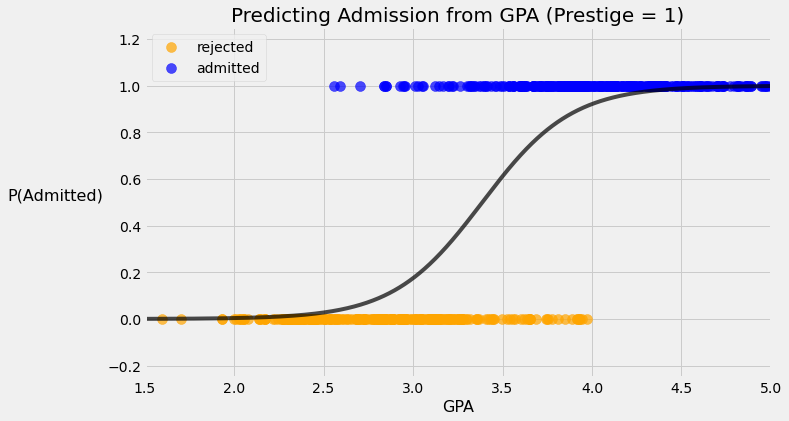

In [60]:
# Visualizing logistic regression probabilities.

# Create figure.
plt.figure(figsize=(10,6))

# Plot the regression line where gpa predicts admit.
x_vals = np.linspace(1, 5, 3000)

# Nicholas Jin - BOS
# Plot line of best fit
plt.plot(x_vals,
         logreg.predict_proba(x_vals.reshape(-1,1))[:,1],
         color='black', alpha=0.7, lw=4)

# Create scatterplot with orange dots for those rejected.
plt.scatter(admit['gpa'][admit['admit'] == 0],
            admit['admit'][admit['admit'] == 0],
            c='orange',
            s=100,
            alpha=0.7,
            label='rejected')

# Create scatterplot with blue dots for those admitted.
plt.scatter(admit['gpa'][admit['admit'] == 1],
            admit['admit'][admit['admit'] == 1],
            c='blue',
            s=100,
            alpha=0.7,
            label='admitted')

# Set labels of axes and title.
plt.ylabel('P(Admitted)', fontsize=16, rotation = 'horizontal', ha = 'right')
plt.yticks(fontsize = 14)
plt.xlabel('GPA', fontsize=16)
plt.xticks(fontsize = 14)
plt.title('Predicting Admission from GPA (Prestige = 1)', fontsize=20)
plt.xlim(1.5, 5)
plt.ylim(-0.25, 1.25)
plt.legend(loc='upper left');

In [61]:
# Step 4: Evaluate model.
accuracy_score(y_test, y_preds_log)

0.8852459016393442

By default, the `.score()` method for classification models gives us the accuracy score.

$$
\begin{eqnarray*}
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{number of total predictions}}
\end{eqnarray*}
$$

<details><summary>Remind me: what does .score() tell me for a regression model?</summary>
    
- The $R^2$ score.
- Remember that $R^2$ is the proportion of variance in our $Y$ values that are explained by our model.
</details>

## Interpretation
#### Down the rabbit hole...

### Using the log-odds —the natural logarithm of the odds.

The combination of converting the "probability of success" to "odds of success," then taking the logarithm of that is called the **logit link function**.

### $$\text{logit}\big(P(Y=1)\big) = \log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

We've bent our line how we want... but how do we interpret our coefficients?

### Odds

Probabilities and odds represent the same thing in different ways. The odds for probability **p** is defined as:

### $$\text{odds}(p) = \frac{p}{1-p}$$

The odds of a probability is a measure of how many times as likely an event is to happen than it is to not happen.

**Example**: Suppose I'm looking at the probability and odds of a specific horse, "Secretariat," winning a race.

- When **`p = 0.5`**: **`odds = 1`**
    - The horse Secretariat is as likely to win as it is to lose.
- When **`p = 0.75`**: **`odds = 3`**
    - The horse Secretariat is three times as likely to win as it is to lose.
- When **`p = 0.40`**: **`odds = 0.666..`**
   - The horse Secretariat is two-thirds as likely to win as it is to lose.

### Interpreting a one-unit change in $X_i$.

$$\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Given this model, a one-unit change in $X_i$ implies a $\beta_i$ unit change in the log odds of success.

**This is annoying**.

We often convert log-odds back to "regular odds" when interpreting our coefficient... our mind understands odds better than the log of odds.

**(BONUS)** So, let's get rid of the log on the left-hand side. Mathematically, we do this by "exponentiating" each side.
$$
\begin{eqnarray*}
\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\Rightarrow \frac{P(Y=1)}{1-P(Y=1)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\end{eqnarray*}
$$

**Interpretation**: A one-unit change in $X_i$ means that success is $e^{\beta_i}$ times as likely.

<details><summary> I want to interpret the coefficient $\hat{\beta}_1$ for my logistic regression model. How would I interpret this coefficient?</summary>
    
- Our model is that $\log\bigg(\frac{P(admit=1)}{1-P(admit=1)}\bigg) = \beta_0 + \beta_1\text{GPA}$.
- As GPA increases by 1, the log-odds of someone being admitted increases by 3.96.
- As GPA increases by 1, someone is $e^{3.96}$ times as likely to be admitted.
- As GPA increases by 1, someone is about 52.4 times as likely to be admitted to grad school.
</details>

> Hint: Use the [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) function.

In [ ]:
print(f'Logistic Regression Coefficient: {}')

In [ ]:
# Use np.exp() to exponentiate the coefficient.


### Alternative Ways of Considering...

We could also consider interpreting or understanding the coefficients in other ways:
- Postive or negative
- Relative size of coefficients
- Concrete example (set values for all variables, then vary the one of interest only to compare the probabilities). 

## Beyond binary classification problems.

Today, we looked at a binary classification problem: was somebody admitted, or not? Many of our classification problems will be binary. Even if the problem isn't binary, we can always force it to be binary. (i.e. Did the stock price increase or decrease?)

However, some of our classification problems won't be binary. You'll see an example of this in a later lesson!

## Conclusion

The goal of logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.

Logistic regression generates the coefficients of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

## Interview Questions

<details><summary>What is the difference between a classification and a regression problem?</summary>
    
- A classification problem has a discrete $Y$ variable. A regression problem has a continuous $Y$ variable.
</details>

<details><summary>What are some of the benefits of logistic regression as a classifier?</summary>

(Answers may vary; this is not an exhaustive list!)
- Logistic regression is a classification algorithm that shares similar properties to linear regression.
- The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.)
- Logistic regression is a very fast model to fit and generate predictions from.
- It is by far the most common classification algorithm.

**Note**: The original interview question was "If you're comparing decision trees and logistic regression, what are the pros and cons of each?"
</details>